# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [371]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.

## Exploratory Data Analysis

In [3]:
print(len(portfolio))
print(len(profile))
print(len(transcript))

10
17000
306534


In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [28]:
transcript.sample(9)

,person,event,value,time
150484,5135ef4c1dbe47c2ac534a57675a2c32,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,402
170070,379bdc8a080b4b14b70d0468e6ce9a75,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414
8146,90e92f7c1af5428ba3b5f3c418017663,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
78729,949c1dc445584287852cce6b8bbd2803,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},192
32086,9b5ef3657ea24e6388e6b7f18eae0f57,transaction,{'amount': 4.88},54
280600,905c7b26eac2451b9b1f0ebc7be8b9fd,transaction,{'amount': 20.98},618
70890,7c04f1c0d5764d878c4301062c245ecd,transaction,{'amount': 265.94},174
299086,da92e3a709964e70a1bdf0375ac3e80a,transaction,{'amount': 0.84},678
277530,fcddf10a62634bc9ab6039b1044db076,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,612


In [31]:
transcript[transcript.event == 'offer received'].sample(5)

,person,event,value,time
205297,3c33fa89263b423688c611b3879a85ce,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},504
117435,153f7ce19d8f4c8294fdc8d758c880c7,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},336
8986,7fbdb682e1cb47b8aa05b7d05cd5d3a6,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
58904,401f773670d94a7488581e99777c6c8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
120393,bfce6d50205a4f6982d87ce80e5d5356,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},336


In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [369]:
# make into bar chart
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [12]:
profile.gender.isna().sum()

2175

In [24]:
profile.dtypes

gender                      object
age                          int64
id                          object
became_member_on    datetime64[ns]
income                     float64
dtype: object

In [19]:
from datetime import datetime

In [22]:
profile['became_member_on'] = profile.became_member_on.astype(str)

In [23]:
# change date column to datetime
profile['became_member_on'] = profile.became_member_on.apply(lambda s: datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8])))
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [36]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [104]:
cols = ['web', 'email', 'mobile', 'social']
for col in cols:
    portfolio[col] = portfolio.channels.apply(lambda x: int(col in x))
portfolio

,reward,channels,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [98]:
def to_list(dict_):
    import pandas as pd
    lst = []
    for i,j in dict_.items():
        temp = [i,j]
        lst.extend(temp)
    return pd.Series({'type': lst[0], 'id' : lst[1]})
to_list(x)    

type                            offer_id
id      9b98b8c7a33c4b65b9aebfe6a799e6d9
dtype: object

In [100]:
%%time
transcript.loc[:,['type', 'id']] = transcript.value.apply(to_list)


Wall time: 1min 3s


,person,event,value,time,type,id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,offer id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [109]:
del transcript['value']
transcript.sample(5)

,person,event,time,type,id
172961,2b45d1b9f77440538af83122e3d14a6c,offer viewed,420,offer id,5a8bc65990b245e5a138643cd4eb9837
202173,f10d90acb03b43e094f755e607388657,offer received,504,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
141723,d3f998b289524c48862d1ed0cd3f7fb6,offer completed,378,offer_id,fafdcd668e3743c1bb461111dcafc2a4
228176,bf6849a39d3640069a65f44f8b01f5da,offer viewed,528,offer id,f19421c1d4aa40978ebb69ca19b0e20d
92471,d1330d5ce5e742d9826a79d574df3172,transaction,240,amount,27.66


In [110]:
del portfolio['channels']
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [170]:
portfolio['offer_detail'] = portfolio[portfolio.columns[:4]].apply(lambda x: ''.join(x.astype(str)), axis=1)
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,offer_detail
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,10107bogo
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,10105bogo
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,004informational
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,557bogo
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,52010discount
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,377discount
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,21010discount
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,003informational
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,555bogo
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,2107discount


In [108]:
profile.rename(columns={'id':'person'}, inplace=True)
profile.head()

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [189]:
portfolio_less_info = portfolio[portfolio.offer_type != 'informational']
final_data = transcript.merge(portfolio_less_info, on='id', how='left')

In [190]:
final_data[final_data.person == '54d9d921c59540fba0e5aea4b7079da0']

,person,event,time,type,id,reward,difficulty,duration,offer_type,web,email,mobile,social,offer_detail
1626,54d9d921c59540fba0e5aea4b7079da0,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,10105bogo
13024,54d9d921c59540fba0e5aea4b7079da0,offer viewed,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,10105bogo
38392,54d9d921c59540fba0e5aea4b7079da0,transaction,84,amount,7.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40947,54d9d921c59540fba0e5aea4b7079da0,transaction,96,amount,14.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40948,54d9d921c59540fba0e5aea4b7079da0,offer completed,96,offer_id,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,10105bogo
45601,54d9d921c59540fba0e5aea4b7079da0,transaction,120,amount,22.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54828,54d9d921c59540fba0e5aea4b7079da0,offer received,168,offer id,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77508,54d9d921c59540fba0e5aea4b7079da0,offer viewed,192,offer id,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101602,54d9d921c59540fba0e5aea4b7079da0,transaction,282,amount,11.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112452,54d9d921c59540fba0e5aea4b7079da0,offer received,336,offer id,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,bogo,0.0,1.0,1.0,1.0,10107bogo


In [115]:
profile.head()

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [116]:
profile.isna().sum()

gender              2175
age                    0
person                 0
became_member_on       0
income              2175
dtype: int64

In [117]:
import seaborn as sns

<AxesSubplot:xlabel='age', ylabel='Count'>

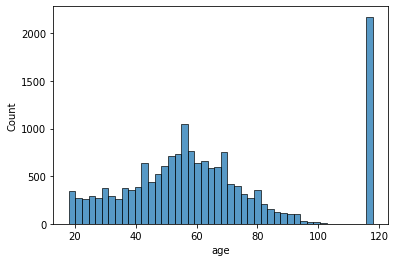

In [118]:
# remove outliers and check if model gets better for it
sns.histplot(profile.age)

In [122]:
outliers = profile[profile.age > 105]
print(len(outliers))
outliers.sample(20)

2175


,gender,age,person,became_member_on,income
9639,None,118,f9774a27b8784133a7afbb234d4fb08f,2017-10-22,NaN
12696,None,118,ff71a5ae9c964d4195f69d15cd2aceeb,2017-09-28,NaN
10850,None,118,125562e434cd48fd9297a5f67111d5ce,2016-01-15,NaN
16037,None,118,17df9c48780d4124b2448aeedb3ba095,2016-06-05,NaN
10737,None,118,53240b77536a401d9f7a507325ac731f,2016-02-01,NaN
8150,None,118,e663954f1ef84059addf01061b9ed576,2017-03-19,NaN
13994,None,118,a770f6bc6b074a4da3c13a783dd7f4ca,2018-07-22,NaN
12960,None,118,ec80a606102e4df891ce8b1c5b168112,2018-04-01,NaN
1767,None,118,4c3ced252b9b4d45bc216b8264021791,2016-01-01,NaN
7704,None,118,dcd1cd7325824551abff5eab7f97a0fe,2016-11-25,NaN


In [129]:
transcript[transcript.person.isin(outliers.person)].event.value_counts()/transcript[transcript.person.isin(outliers.person)].shape[0]

transaction        0.444036
offer received     0.289471
offer viewed       0.232885
offer completed    0.033608
Name: event, dtype: float64

In [130]:
transcript[~transcript.person.isin(outliers.person)].event.value_counts()/transcript[~transcript.person.isin(outliers.person)].shape[0]

transaction        0.454451
offer received     0.243806
offer viewed       0.182797
offer completed    0.118946
Name: event, dtype: float64

In [131]:
final_data.head()

,person,event,time,type,id,reward,difficulty,duration,offer_type,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [143]:
grp = final_data[(final_data.person == '1acb3e87e3304271a3c917cc80a53780') & (final_data.offer_type == 'bogo')]
grp

,person,event,time,type,id,reward,difficulty,duration,offer_type,web,email,mobile,social
9950,1acb3e87e3304271a3c917cc80a53780,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
35236,1acb3e87e3304271a3c917cc80a53780,offer viewed,66,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
46358,1acb3e87e3304271a3c917cc80a53780,offer completed,120,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
58984,1acb3e87e3304271a3c917cc80a53780,offer received,168,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
103596,1acb3e87e3304271a3c917cc80a53780,offer viewed,288,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
105714,1acb3e87e3304271a3c917cc80a53780,offer completed,300,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
120804,1acb3e87e3304271a3c917cc80a53780,offer received,336,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
132252,1acb3e87e3304271a3c917cc80a53780,offer viewed,348,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
156438,1acb3e87e3304271a3c917cc80a53780,offer received,408,offer id,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,bogo,0.0,1.0,1.0,1.0
181993,1acb3e87e3304271a3c917cc80a53780,offer completed,438,offer_id,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [158]:
def grp_stat(df):
    """
    returns % of offer viewed and offer completed out of the total offers received.
    
    """
    stat =df.event.value_counts()
    try:
        offer_viewed = round(stat['offer viewed']/stat['offer received'], 2)
    except KeyError:
        offer_viewed = 0
    try:
        offer_completed = round(stat['offer completed']/stat['offer received'], 2)
    except KeyError:
        offer_completed = 0
    return pd.Series({'viewed_perc': offer_viewed,
                     'completed_perc': offer_completed})

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,offer_detail
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,10107bogo
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,10105bogo
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,004informational
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,557bogo
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,52010discount
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,377discount
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,21010discount
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,003informational
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,555bogo
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,2107discount


In [191]:
print(len(final_data))
offer_stat = final_data.groupby(['person','offer_detail'],as_index=False).apply(grp_stat)
print(len(offer_stat))
offer_stat.head()

306534
50637


,person,offer_detail,viewed_perc,completed_perc
0,0009655768c64bdeb2e877511632db8f,21010discount,1.0,1.0
1,0009655768c64bdeb2e877511632db8f,2107discount,0.0,1.0
2,0009655768c64bdeb2e877511632db8f,555bogo,1.0,1.0
3,00116118485d4dfda04fdbaba9a87b5c,555bogo,1.0,0.0
4,0011e0d4e6b944f998e987f904e8c1e5,377discount,1.0,1.0


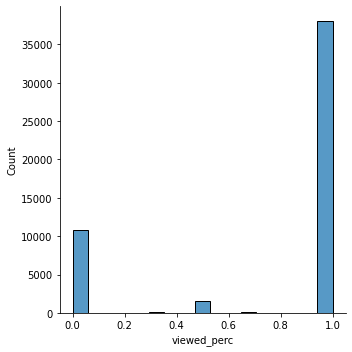

In [192]:
sns.displot(offer_stat.viewed_perc)

In [198]:
def bin_data(x,name):
    if x == 0:
        return 'low_{}'.format(name)
    elif x == 1:
        return 'high_{}'.format(name)
    else:
        return 'mid_{}'.format(name)

In [202]:
offer_stat['view'] = offer_stat.viewed_perc.apply(lambda x: bin_data(x,name='view'))
offer_stat.sample(10)

,person,offer_detail,viewed_perc,completed_perc,view
8697,2d417224c49c4d1eb3ad45275ae43662,377discount,1.0,0.00,high_view
26607,86393faabf374030a53989634fd94933,21010discount,1.0,0.00,high_view
47434,efa8dd634f544ef99a6fca10c60629c6,555bogo,1.0,1.00,high_view
24456,7b74e68b25754abb968231adc71c7e3a,557bogo,1.0,1.00,high_view
9659,319abe74a62949209cb8a5531f89b3fd,2107discount,0.0,0.33,low_view
32225,a12fba072dae4e3aae2e1b4b92b92aa1,10105bogo,1.0,1.00,high_view
17848,5a89bd9fa2374a81bba2373dee6ffbc9,10105bogo,1.0,1.00,high_view
10673,36e719e6fc9f4d01a2d96f27f7ae0b8a,557bogo,1.0,1.00,high_view
3694,1314cb7b712649af9acf1ac19aadd267,52010discount,0.5,0.00,mid_view
32975,a4cd8d3f09a44dd09960e7e96df805a5,10107bogo,1.0,1.00,high_view


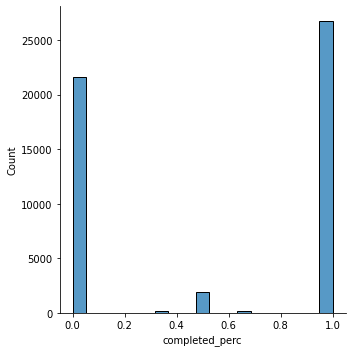

In [193]:
sns.displot(offer_stat.completed_perc)

In [203]:
offer_stat['complete'] = offer_stat.completed_perc.apply(lambda x: bin_data(x,name='complete'))
offer_stat.sample(10)

,person,offer_detail,viewed_perc,completed_perc,view,complete
4543,17c803219d1348d4a016691c947de0ed,377discount,1.0,0.0,high_view,low_complete
30014,96fbfcfa100443c3994aa3bcda55069e,557bogo,1.0,0.5,high_view,mid_complete
34506,ac924b1097a348d3b101cab1218aa83b,21010discount,1.0,1.0,high_view,high_complete
4879,196cdd07f88b486a81cd5aaaea6d022d,52010discount,0.0,0.0,low_view,low_complete
31890,9fa090f47ea946b7a715b8a7ff1eaa97,10107bogo,1.0,0.0,high_view,low_complete
39937,c9044e16606e462b87985518a0b048b6,52010discount,1.0,1.0,high_view,high_complete
30465,99148a450059428180ed37cb9ab01f62,555bogo,1.0,1.0,high_view,high_complete
10149,341d5d291e4d413ebea827b44c57fe4a,557bogo,1.0,0.0,high_view,low_complete
10831,3798869304074ff1b1bb1cbf1b352676,557bogo,1.0,1.0,high_view,high_complete
22104,6f9c0edc272d4457986e63abfbfa2f41,2107discount,1.0,1.0,high_view,high_complete


In [206]:
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,offer_detail
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,10107bogo
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,10105bogo
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,004informational
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,557bogo
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,52010discount
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,377discount
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,21010discount
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,003informational
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,555bogo
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,2107discount


In [210]:
offer_stat.groupby(['view','complete'], as_index=False).agg({'person':'count', 'offer_detail': [lambda x: x.value_counts().index[0:3],lambda x: x.value_counts()[0:3]]})

view       complete person                            offer_detail  \
                             count                              <lambda_0>   
0  high_view  high_complete  21835   [21010discount, 377discount, 555bogo]   
1  high_view   low_complete  14829         [10105bogo, 10107bogo, 555bogo]   
2  high_view   mid_complete   1384       [555bogo, 377discount, 10105bogo]   
3   low_view  high_complete   4206  [52010discount, 557bogo, 2107discount]   
4   low_view   low_complete   6275  [52010discount, 2107discount, 557bogo]   
5   low_view   mid_complete    330  [52010discount, 557bogo, 2107discount]   
6   mid_view  high_complete    711  [557bogo, 2107discount, 52010discount]   
7   mid_view   low_complete    537  [2107discount, 52010discount, 557bogo]   
8   mid_view   mid_complete    530  [557bogo, 2107discount, 52010discount]   

                       
           <lambda_1>  
0  [4178, 3990, 3265]  
1  [3253, 2760, 2374]  
2     [318, 240, 225]  
3   [1376, 1181, 977]  
4  [2468, 1612, 1417]  
5       [130, 99, 88]  
6     [180, 163, 154]  
7       [123, 97, 93]  
8      [146, 136, 77]

#### Mode
1. No high complete is less than 7 days
2. No low complete has difficulty less than 10
3. reward of all mid-complete is 5
4. all the low view have difficulty of 20
------> Check the demography too

In [211]:
offer_stat.head()

,person,offer_detail,viewed_perc,completed_perc,view,complete
0,0009655768c64bdeb2e877511632db8f,21010discount,1.0,1.0,high_view,high_complete
1,0009655768c64bdeb2e877511632db8f,2107discount,0.0,1.0,low_view,high_complete
2,0009655768c64bdeb2e877511632db8f,555bogo,1.0,1.0,high_view,high_complete
3,00116118485d4dfda04fdbaba9a87b5c,555bogo,1.0,0.0,high_view,low_complete
4,0011e0d4e6b944f998e987f904e8c1e5,377discount,1.0,1.0,high_view,high_complete


In [212]:
profile.head()

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [225]:
all_data = offer_stat.merge(profile, on = 'person', how = 'left')
print(len(all_data))
all_data.head()

50637


,person,offer_detail,viewed_perc,completed_perc,view,complete,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,21010discount,1.0,1.0,high_view,high_complete,M,33,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,2107discount,0.0,1.0,low_view,high_complete,M,33,2017-04-21,72000.0
2,0009655768c64bdeb2e877511632db8f,555bogo,1.0,1.0,high_view,high_complete,M,33,2017-04-21,72000.0
3,00116118485d4dfda04fdbaba9a87b5c,555bogo,1.0,0.0,high_view,low_complete,None,118,2018-04-25,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,377discount,1.0,1.0,high_view,high_complete,O,40,2018-01-09,57000.0


age and income distribution facet by view and complete

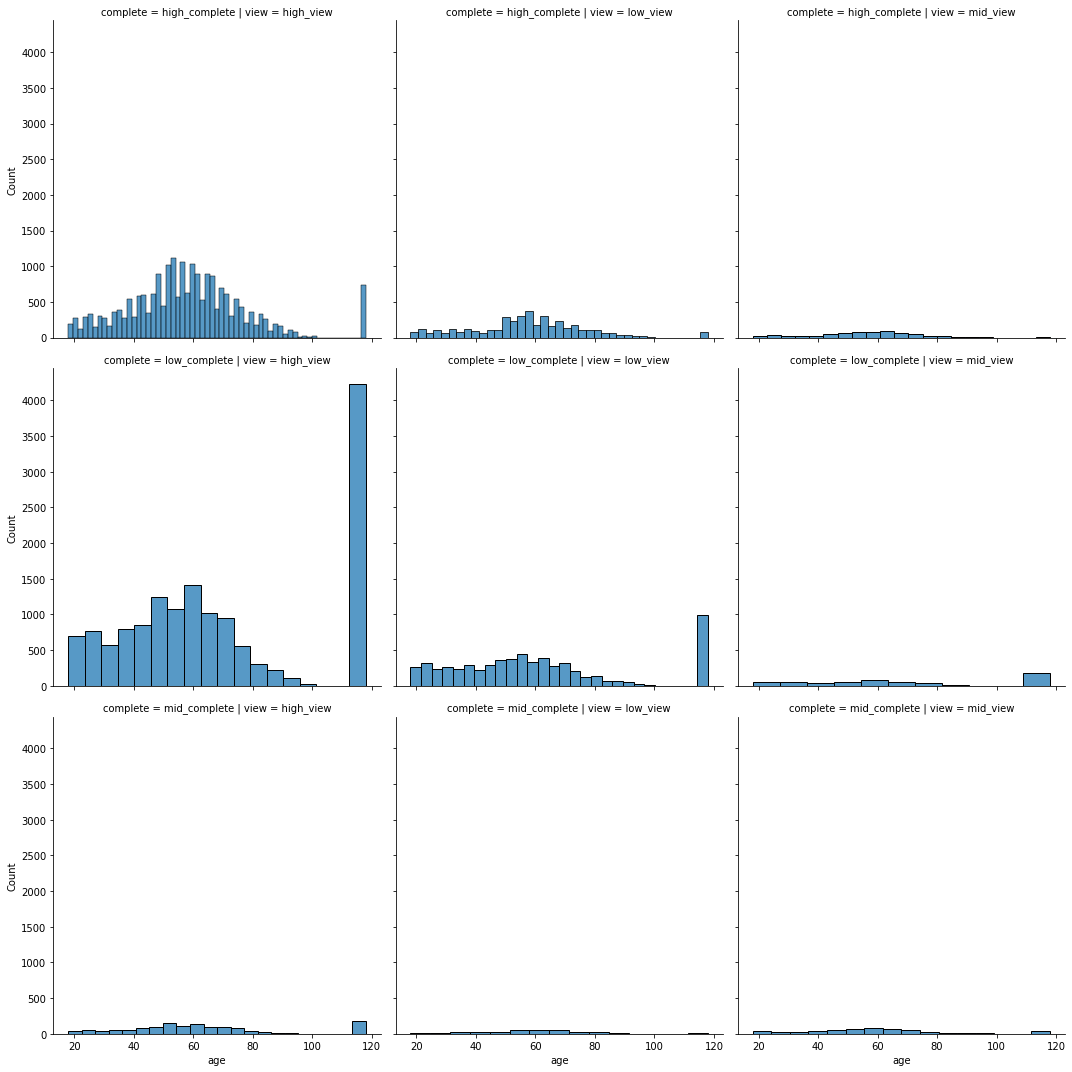

In [227]:
g = sns.FacetGrid(all_data, col="view",  row="complete", height=5)
g.map_dataframe(sns.histplot, x="age");

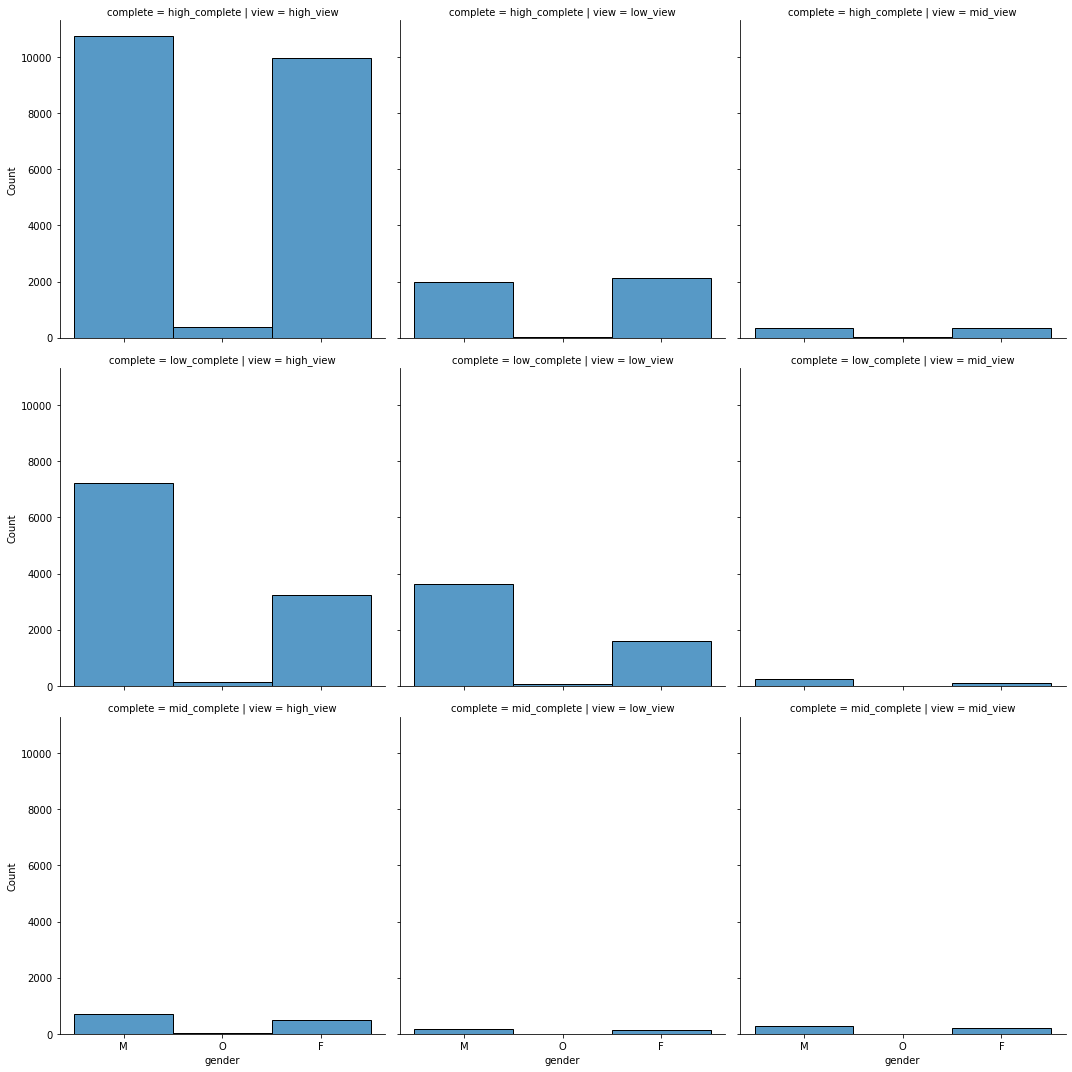

In [228]:
g = sns.FacetGrid(all_data, col="view",  row="complete", height=5)
g.map_dataframe(sns.histplot, x="gender");

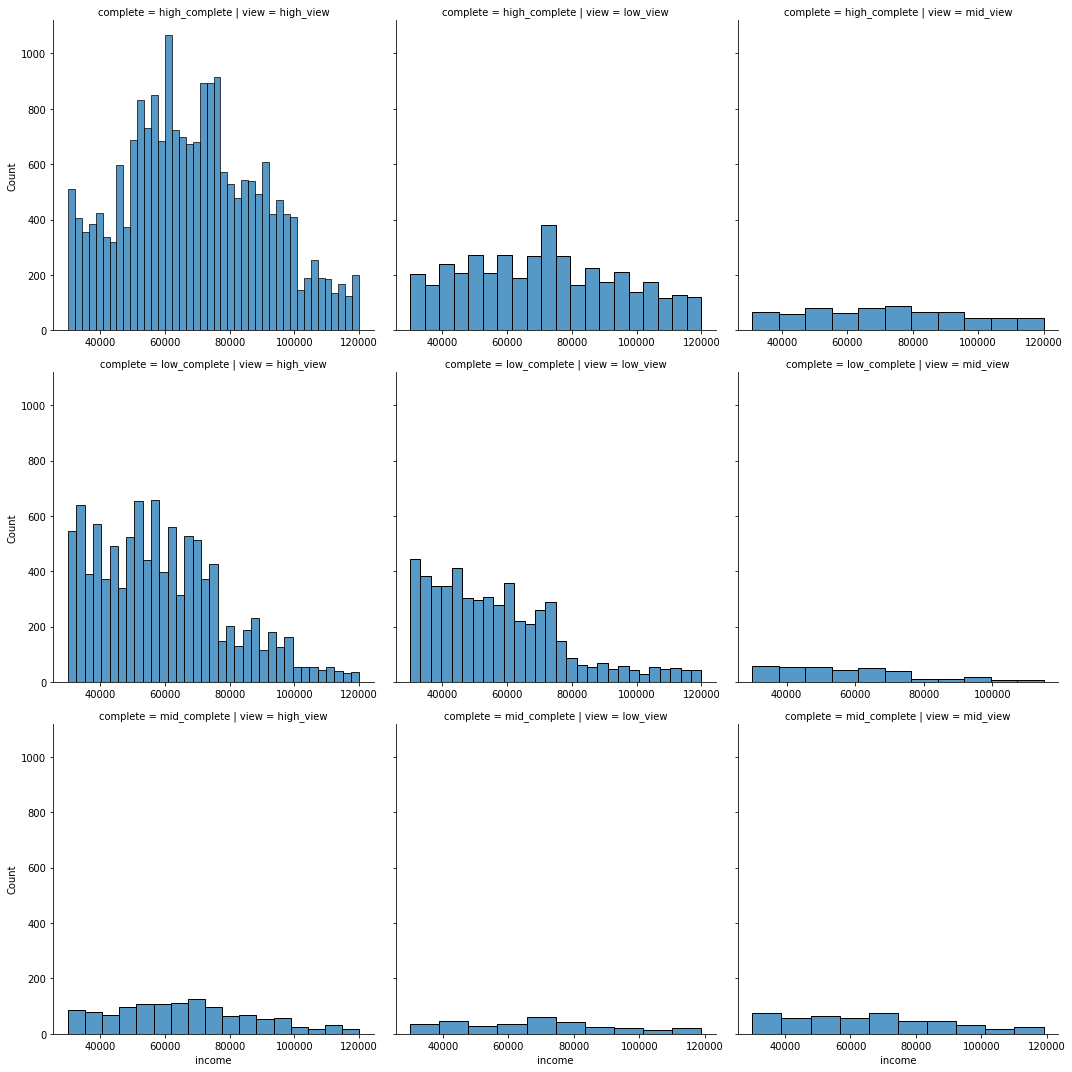

In [230]:
g = sns.FacetGrid(all_data, col="view",  row="complete", height=5, sharex=False)
g.map_dataframe(sns.histplot, x="income");

In [194]:
offer_stat.completed_perc.value_counts()

1.00    26752
0.00    21641
0.50     1921
0.67      154
0.33      152
0.75        9
0.25        5
0.60        1
0.20        1
0.40        1
Name: completed_perc, dtype: int64

In [195]:
offer_stat.viewed_perc.value_counts()

1.00    38048
0.00    10811
0.50     1524
0.67      138
0.33      104
0.75        7
0.25        4
0.20        1
Name: viewed_perc, dtype: int64

In [196]:
offer_stat.head()

,person,offer_detail,viewed_perc,completed_perc
0,0009655768c64bdeb2e877511632db8f,21010discount,1.0,1.0
1,0009655768c64bdeb2e877511632db8f,2107discount,0.0,1.0
2,0009655768c64bdeb2e877511632db8f,555bogo,1.0,1.0
3,00116118485d4dfda04fdbaba9a87b5c,555bogo,1.0,0.0
4,0011e0d4e6b944f998e987f904e8c1e5,377discount,1.0,1.0


In [245]:
final_data = final_data[~final_data.id.isin(['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837'])]

In [246]:
idx = round(0.85 * len(final_data))
data = final_data[['person', 'event', 'offer_detail']]
train_data = data.iloc[:idx,]
test_data = data.iloc[idx:,]

In [300]:
train_data_df = train_data.groupby(['person','offer_detail'], as_index=False).agg({'event': lambda x: sum(x=='offer completed')})
test_data_df = test_data.groupby(['person','offer_detail'], as_index=False).agg({'event': lambda x: sum(x=='offer completed')})


In [301]:
person_offer_df = train_data_df.groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack()
person_offer_df_test = test_data_df.groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack()

person_offer_df.head()

offer_detail,10105bogo,10107bogo,21010discount,2107discount,377discount,52010discount,555bogo,557bogo
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0
0020c2b971eb4e9188eac86d93036a77,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0


In [302]:
person_offer_mat = person_offer_df.values
person_offer_mat_test = person_offer_df_test.values

In [270]:
import tqdm
from tqdm import notebook, trange

In [284]:
def FunkSVD(ratings_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0] # number of rows in the matrix
    n_movies = ratings_mat.shape[1] # number of movies in the matrix
    num_ratings = n_users * n_movies # total number of ratings in the matrix
    
    # initialize the user and movie matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users,latent_features) # user matrix filled with random values of shape user x latent 
    movie_mat = np.random.rand(latent_features, n_movies) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for i in notebook.trange(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-movie pair
        for j in range(num_ratings):
            row = j//n_movies
            col = j%n_movies
                # if the rating exists
            if not np.isnan(ratings_mat[row,col]): 
                    # compute the error as the actual minus the dot product of the user and movie latent features
                error = ratings_mat[row,col] - np.dot(user_mat[row,:], movie_mat[:,col])
                    # Keep track of the total sum of squared errors for the matrix
                sse_accum += error**2
                    # update the values in each matrix in the direction of the gradient
                for k in range(latent_features):
                    user_mat[row,k] += 2*learning_rate*movie_mat[k,col]*error
                    movie_mat[k,col] += 2*learning_rate*user_mat[row,k]*error # try and update movie_mat after all user_mat is updated and see if it changes anything
        # print results for iteration
        print(i, '|', sse_accum)
        if i == 3000:
            learning_rate = learning_rate*2
    return user_mat, movie_mat 

In [368]:
person_mat, offer_mat = FunkSVD(person_offer_mat, latent_features=15, learning_rate=0.001, iters=3000)

Optimization Statistics
Iterations | Mean Squared Error 


  0%|          | 0/3000 [00:00<?, ?it/s]

0 | 22921.284736323243
1 | 12899.527856283114
2 | 12631.746942824488
3 | 12594.580378361881
4 | 12585.404791460629
5 | 12579.613227484882
6 | 12574.217221016237
7 | 12568.86118698922
8 | 12563.506195566311
9 | 12558.149281348953
10 | 12552.790722000487
11 | 12547.430757366219
12 | 12542.069467079038
13 | 12536.706856551687
14 | 12531.342902951033
15 | 12525.977573085178
16 | 12520.610829797828
17 | 12515.242634182425
18 | 12509.872946336476
19 | 12504.50172561167
20 | 12499.128930692443
21 | 12493.75451961829
22 | 12488.37844978245
23 | 12483.00067792828
24 | 12477.621160139626
25 | 12472.239851832452
26 | 12466.856707744913
27 | 12461.47168192725
28 | 12456.084727733398
29 | 12450.695797809389
30 | 12445.304844084254
31 | 12439.911817759192
32 | 12434.516669297194
33 | 12429.119348412958
34 | 12423.71980406156
35 | 12418.31798442794
36 | 12412.913836915355
37 | 12407.507308135466
38 | 12402.098343895861
39 | 12396.686889188439
40 | 12391.272888178686
41 | 12385.85628419356
42 | 12380.

336 | 9792.434869410861
337 | 9774.396021586566
338 | 9756.252148163121
339 | 9738.003443539148
340 | 9719.650127032966
341 | 9701.192443130602
342 | 9682.630661724606
343 | 9663.965078339303
344 | 9645.19601434711
345 | 9626.32381717014
346 | 9607.348860470702
347 | 9588.27154432926
348 | 9569.09229540753
349 | 9549.811567100343
350 | 9530.429839670776
351 | 9510.947620373634
352 | 9491.36544356258
353 | 9471.683870782597
354 | 9451.903490847451
355 | 9432.024919901574
356 | 9412.048801465484
357 | 9391.975806465389
358 | 9371.806633246766
359 | 9351.542007570339
360 | 9331.182682591138
361 | 9310.729438821767
362 | 9290.183084076565
363 | 9269.544453398219
364 | 9248.81440896902
365 | 9227.993840000996
366 | 9207.08366260945
367 | 9186.08481966972
368 | 9164.998280652162
369 | 9143.825041442922
370 | 9122.566124143372
371 | 9101.222576851362
372 | 9079.795473426413
373 | 9058.285913233014
374 | 9036.695020868052
375 | 9015.023945868961
376 | 8993.273862404152
377 | 8971.44596894296
3

677 | 3495.9449093430494
678 | 3484.0172435713807
679 | 3472.1100917245926
680 | 3460.2233731993256
681 | 3448.357010855211
682 | 3436.510930973623
683 | 3424.6850632151923
684 | 3412.8793405781767
685 | 3401.093699355875
686 | 3389.328079094077
687 | 3377.582422548574
688 | 3365.8566756420314
689 | 3354.1507874213235
690 | 3342.464710013744
691 | 3330.798398584652
692 | 3319.1518112935073
693 | 3307.524909250421
694 | 3295.9176564731383
695 | 3284.330019842817
696 | 3272.7619690608594
697 | 3261.213476605281
698 | 3249.684517686723
699 | 3238.175070204971
700 | 3226.6851147052766
701 | 3215.214634334842
702 | 3203.7636147987328
703 | 3192.3320443168413
704 | 3180.9199135799454
705 | 3169.5272157063023
706 | 3158.1539461985312
707 | 3146.8001028997114
708 | 3135.4656859507627
709 | 3124.150697746793
710 | 3112.8551428944634
711 | 3101.579028168733
712 | 3090.3223624702564
713 | 3079.0851567828918
714 | 3067.867424130776
715 | 3056.6691795364727
716 | 3045.4904399782718
717 | 3034.33122

1010 | 778.0115193047786
1011 | 773.8513228902376
1012 | 769.7112983508131
1013 | 765.5913758195712
1014 | 761.4914853413845
1015 | 757.4115568774449
1016 | 753.351520309807
1017 | 749.3113054458298
1018 | 745.290842022561
1019 | 741.290059711121
1020 | 737.3088881210408
1021 | 733.3472568045661
1022 | 729.4050952608567
1023 | 725.4823329402111
1024 | 721.5788992482899
1025 | 717.6947235501339
1026 | 713.8297351742909
1027 | 709.9838634169074
1028 | 706.1570375456553
1029 | 702.3491868037288
1030 | 698.5602404137127
1031 | 694.7901275815583
1032 | 691.0387775002714
1033 | 687.3061193538531
1034 | 683.5920823209539
1035 | 679.8965955786224
1036 | 676.2195883059907
1037 | 672.560989687844
1038 | 668.9207289182878
1039 | 665.298735204248
1040 | 661.6949377689981
1041 | 658.1092658556109
1042 | 654.5416487304155
1043 | 650.9920156863567
1044 | 647.4602960463781
1045 | 643.9464191666897
1046 | 640.4503144400894
1047 | 636.9719112991249
1048 | 633.5111392193603
1049 | 630.067927722485
1050 |

1334 | 129.945330737186
1335 | 129.23428494616934
1336 | 128.5272674066128
1337 | 127.82425521432432
1338 | 127.12522558971499
1339 | 126.43015587722184
1340 | 125.73902354472038
1341 | 125.0518061829667
1342 | 124.36848150501359
1343 | 123.68902734563979
1344 | 123.01342166077745
1345 | 122.3416425269485
1346 | 121.67366814068644
1347 | 121.00947681797889
1348 | 120.34904699369991
1349 | 119.69235722104101
1350 | 119.03938617095622
1351 | 118.39011263158977
1352 | 117.7445155077286
1353 | 117.10257382023613
1354 | 116.46426670549532
1355 | 115.82957341485992
1356 | 115.1984733140909
1357 | 114.57094588281225
1358 | 113.94697071395818
1359 | 113.3265275132201
1360 | 112.70959609849893
1361 | 112.09615639936804
1362 | 111.48618845651694
1363 | 110.87967242121445
1364 | 110.27658855476588
1365 | 109.6769172279742
1366 | 109.08063892060142
1367 | 108.48773422082682
1368 | 107.89818382472644
1369 | 107.31196853572244
1370 | 106.72906926405898
1371 | 106.14946702627631
1372 | 105.5731429446

1658 | 23.716488801044203
1659 | 23.599115552948312
1660 | 23.48237085425867
1661 | 23.366251172041377
1662 | 23.250752993894384
1663 | 23.13587282782393
1664 | 23.02160720212679
1665 | 22.90795266526948
1666 | 22.794905785766833
1667 | 22.68246315206605
1668 | 22.570621372428295
1669 | 22.459377074810114
1670 | 22.34872690674849
1671 | 22.238667535244236
1672 | 22.129195646646732
1673 | 22.02030794654123
1674 | 21.912001159631565
1675 | 21.80427202963061
1676 | 21.697117319145903
1677 | 21.590533809569212
1678 | 21.48451830096238
1679 | 21.37906761195129
1680 | 21.27417857961297
1681 | 21.16984805936713
1682 | 21.066072924867356
1683 | 20.962850067894284
1684 | 20.860176398248203
1685 | 20.758048843639965
1686 | 20.656464349589307
1687 | 20.555419879315814
1688 | 20.454912413635576
1689 | 20.35493895085769
1690 | 20.2554965066792
1691 | 20.156582114084888
1692 | 20.058192823241047
1693 | 19.960325701396695
1694 | 19.862977832783166
1695 | 19.766146318510295
1696 | 19.669828276469723
1

1981 | 5.372377293463012
1982 | 5.349905971865542
1983 | 5.327543335711175
1984 | 5.305288820232351
1985 | 5.28314186375245
1986 | 5.261101907668229
1987 | 5.23916839643254
1988 | 5.217340777536571
1989 | 5.195618501492608
1990 | 5.174001021816945
1991 | 5.152487795012731
1992 | 5.131078280552823
1993 | 5.109771940862763
1994 | 5.088568241304494
1995 | 5.067466650158967
1996 | 5.046466638609765
1997 | 5.025567680726959
1998 | 5.004769253449908
1999 | 4.984070836571797
2000 | 4.963471912722521
2001 | 4.942971967353495
2002 | 4.92257048872049
2003 | 4.9022669678687745
2004 | 4.882060898616522
2005 | 4.861951777539373
2006 | 4.841939103954685
2007 | 4.822022379905969
2008 | 4.802201110147189
2009 | 4.782474802127812
2010 | 4.76284296597729
2011 | 4.743305114489404
2012 | 4.723860763107943
2013 | 4.704509429910955
2014 | 4.685250635596382
2015 | 4.666083903466698
2016 | 4.647008759414409
2017 | 4.628024731907302
2018 | 4.609131351973906
2019 | 4.590328153188819
2020 | 4.571614671658447
202

2303 | 1.6260684733296549
2304 | 1.6208781113214357
2305 | 1.6157096840807204
2306 | 1.6105630882533966
2307 | 1.6054382210062106
2308 | 1.6003349800242317
2309 | 1.5952532635079821
2310 | 1.5901929701706996
2311 | 1.5851539992357053
2312 | 1.5801362504334837
2313 | 1.5751396239992823
2314 | 1.5701640206701817
2315 | 1.5652093416826742
2316 | 1.5602754887696402
2317 | 1.5553623641582237
2318 | 1.5504698705667224
2319 | 1.5455979112023657
2320 | 1.5407463897584366
2321 | 1.5359152104118914
2322 | 1.531104277820763
2323 | 1.5263134971215426
2324 | 1.5215427739265996
2325 | 1.5167920143219373
2326 | 1.5120611248643179
2327 | 1.5073500125791004
2328 | 1.5026585849575052
2329 | 1.4979867499543265
2330 | 1.493334415985392
2331 | 1.4887014919251886
2332 | 1.484087887104331
2333 | 1.4794935113073495
2334 | 1.4749182747700125
2335 | 1.470362088177218
2336 | 1.4658248626604544
2337 | 1.4613065097955473
2338 | 1.4568069416001936
2339 | 1.4523260705317416
2340 | 1.4478638094848781
2341 | 1.4434200

2621 | 0.6942052730424959
2622 | 0.6926975348574578
2623 | 0.6911950915973327
2624 | 0.6896979210238544
2625 | 0.6882060010009107
2626 | 0.6867193094940799
2627 | 0.6852378245701249
2628 | 0.6837615243965515
2629 | 0.6822903872409884
2630 | 0.6808243914708161
2631 | 0.6793635155526819
2632 | 0.6779077380518631
2633 | 0.6764570376319754
2634 | 0.6750113930544217
2635 | 0.6735707831777894
2636 | 0.672135186957628
2637 | 0.6707045834457283
2638 | 0.6692789517898116
2639 | 0.6678582712329851
2640 | 0.6664425211132776
2641 | 0.665031680863272
2642 | 0.6636257300094599
2643 | 0.6622246481720047
2644 | 0.6608284150640724
2645 | 0.6594370104915266
2646 | 0.658050414352449
2647 | 0.6566686066366116
2648 | 0.6552915674251395
2649 | 0.6539192768899624
2650 | 0.6525517152934823
2651 | 0.6511888629880268
2652 | 0.6498307004154728
2653 | 0.6484772081067932
2654 | 0.6471283666816359
2655 | 0.6457841568479006
2656 | 0.6444445594012392
2657 | 0.6431095552247414
2658 | 0.6417791252884203
2659 | 0.640453

2935 | 0.3982307985854768
2936 | 0.3976656922424884
2937 | 0.39710212296388947
2938 | 0.39654008513644246
2939 | 0.3959795731702153
2940 | 0.39542058149846687
2941 | 0.39486310457761875
2942 | 0.3943071368870365
2943 | 0.39375267292905086
2944 | 0.3931997072287134
2945 | 0.39264823433385015
2946 | 0.3920982488148502
2947 | 0.3915497452645807
2948 | 0.39100271829834377
2949 | 0.39045716255369284
2950 | 0.3899130726904259
2951 | 0.3893704433903627
2952 | 0.38882926935739937
2953 | 0.38828954531727905
2954 | 0.387751266017566
2955 | 0.38721442622748925
2956 | 0.38667902073794386
2957 | 0.38614504436130226
2958 | 0.38561249193133135
2959 | 0.3850813583031341
2960 | 0.3845516383530543
2961 | 0.3840233269785288
2962 | 0.3834964190980671
2963 | 0.38297090965105607
2964 | 0.3824467935978055
2965 | 0.38192406591931594
2966 | 0.3814027216172872
2967 | 0.38088275571395913
2968 | 0.38036416325208194
2969 | 0.3798469392947864
2970 | 0.37933107892543344
2971 | 0.3788165772477049
2972 | 0.37830342938

  0%|          | 0/13 [00:00<?, ?it/s]

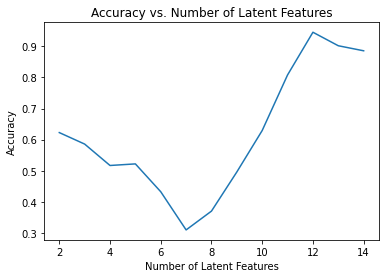

In [378]:
num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = person_mat[:, :k], offer_mat[:k, :]
    
    # take dot product
    person_offer_est = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(person_offer_mat, person_offer_est))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(person_offer_mat)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

  0%|          | 0/13 [00:00<?, ?it/s]

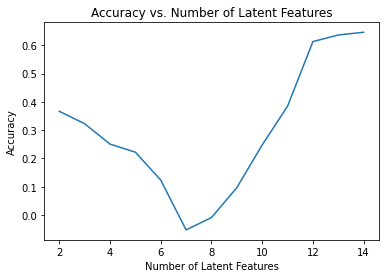

In [381]:
subset_test = person_offer_df_test[person_offer_df_test.index.isin(person_offer_df.index)]

row_idx = np.where(person_offer_df.index.isin(subset_test.index))[0]
#col_idx = np.where(person_offer_df.columns.isin(subset_test.columns))[0]

n = len(row_idx) # no of users in test that can be predicted from train
#m = len(col_idx) # no of features in test that can be predicted from train

num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = person_mat[row_idx, :k], offer_mat[:k, :]
    
    # take dot product
    person_offer_est = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(subset_test.values, person_offer_est))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(subset_test.values)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [387]:
k=12
sse_naive = 0
sse = 0
acc = []
acc_naive = []
person_list = np.intersect1d(person_offer_df_test.index,person_offer_df.index)

for i in notebook.trange(len(person_list)):
    person = person_list[i]
    row = np.where(person_offer_df.index == person)[0][0]
    pred = np.dot(person_mat[row,:k], offer_mat[:k,])
    pred_naive = 0
    actual = person_offer_df_test.loc[person].values
    error = actual-pred
    error_naive = actual - pred_naive
    
    sse += np.nansum(error**2)
    acc.append(np.nansum(np.abs(error)))
    
    acc_naive.append(np.nansum(np.abs(error_naive)))
    sse_naive += np.nansum(error_naive**2)
    
n_notna = (~np.isnan(person_offer_mat_test)).sum()
mse = sse/n_notna
accur = 1- sum(acc)/n_notna
mse_naive = sse_naive/n_notna
accur_naive = 1- sum(acc_naive)/n_notna
print('mse', mse,'accuracy', accur)
print('mse_naive', mse_naive, 'accuracy naive', accur_naive)

  0%|          | 0/8758 [00:00<?, ?it/s]

mse 0.5115007004235841 accuracy 0.3927791451820293
mse_naive 0.6930703085483055 accuracy naive 0.30692969145169446
